## Physics-Informed Neural Networks for 1D Burgers Equation

### Introduction

Physics-Informed Neural Networks (PINNs), introduced by *Raissi et al. (2019)*, represent a transformative approach that seamlessly integrates physical laws into the training of neural networks. Unlike traditional neural networks that rely solely on data-driven methodologies, PINNs leverage the underlying governing equations (such as partial differential equations) directly within the loss function of the network.

The central idea behind PINNs is to encode known physical constraints into the neural network's optimization process (basically the loss function), enabling the network not only to fit observational data but also to adhere closely to the underlying physics of the problem. This approach results in neural networks that are inherently consistent with physical laws, making PINNs highly effective in scenarios where data might be sparse or noisy.

PINNs have found applications across various scientific and engineering domains, including fluid dynamics, solid mechanics, quantum mechanics, and more. Their primary advantage is the ability to yield physically accurate predictions with fewer or (no observed) training data points and improved interpretability.

In general, PINNs are unsupervised, but they can be augmented with available data. However, employing PINNs also introduces specific challenges, such as ensuring adequate convergence during training, balancing the contribution of data-fitting (if data is present) and physics-based losses, and managing the computational complexity associated with evaluating the governing equations.

In [1]:
import os

#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pathlib import Path
from pyDOE import lhs
import torch.optim as optim     #optimizer
import time

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

cuda
NVIDIA RTX A6000


### Problem Setup

We consider the Burgers equation in one-dimension, which is a quasi-linear parabolic partial differential equation given as:
\begin{equation}
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \qquad 0 < x < 1, t > 0,
\end{equation}
with initial condition
$$
    u(x,0) = sin(\pi x), \qquad 0< x < 1,
$$
and (homogenous) boundary conditions  
$$
    u(0,t) =  u(1,t) = 0,  \qquad t > 0.
$$

> Note: The exact solution of the above Burger's equation can be obtained using the Hopf-Cole transformation, that transforms the equation into a linear heat equation.

To solve using PINNs, define a residual $f(t, x)$ as:
\begin{equation}
f := \frac{\partial u_{\theta}}{\partial t} + u_{\theta} \frac{\partial u_{\theta}}{\partial x} - \nu \frac{\partial^2 u_{\theta}}{\partial x^2},
\end{equation}
where $ u_{\theta}(x, t)$ is the velocity in the Burgers equation, now represented as a neural network (i.e is the output of a neural network).

**Our goal is to let $f \approx 0 $, so that our neural network output $u_{\theta}$ will satisfy the Burgers equation (thus, a solution!!).**

What makes a PINN different from a vanilla neural network is basically the loss function. In a PINN, the neural network parameters are trained by minimizing a composite loss function:
$$
MSE = MSE_u + MSE_f,
$$
where
$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}\left| u_{\theta}(t_u^i, x_u^i) - u^i \right|^2,
$$
and,
$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}\left| f(t_f^i, x_f^i) \right|^2.
$$

In this formulation:

* $ (t_u^i, x_u^i, u^i)$ are observed data points with known values of the solution $ u $, such as the boundary points and/or data from a dataset (or exeperiments).

* $ (t_f^i, x_f^i)$ are collocation points used to enforce the differential equation residual $ f(t,x) \approx 0 $.

> How do we compute the derivatives required for evaluating $ f(t,x) $? They are computed using automatic differentiation (or some known numerical differencing techniques, though this is less common), enabling the simultaneous enforcement of data-fitting and physical constraints.

> In this Notebook, we take $\nu = 1.0$

### Configuration and Data Generation

In [2]:
class config:
  def __init__(self):
    #The training parameters
    self.nu = 0.01/torch.pi
    self.x0 = -1  #x0 :Left boundary point
    self.xf = 1  #xf (x final): Right boundary point
    self.layers = [2,125, 256, 125, 1]
    self.spatial_resolution =  300
    self.temporal_resolution = 150

    #Defining the initial condition
    self.init_cond = lambda x: -torch.sin(torch.pi * x) 
    self.col_pts = 10000 #Number of collocation points (points in the domain to train on)
    self.num_epoch = 10000

    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoint_burgers1d_pinn'


cfg = config()

In [59]:
#Automatic differentiation
def dfx(f, x):
    gouts = torch.ones_like(f)  # To ensure it matches shape of output f
    return grad(f, x, grad_outputs=gouts, create_graph=True)[0]

In [60]:
x = torch.linspace(cfg.x0,cfg.xf, cfg.col_pts//4).view(-1,1).float().to(device) #Quarter of training points for the boundary
t = torch.linspace(0,1, cfg.col_pts//4).view(-1,1).float().to(device)
#We will be training on random points inside the domain Omega = (-1,1) x (0,1), and on the boundary and initial points
#The points inside the domain will be generated randomly using Latin Hypercube Sampling

x_inner = cfg.x0 + (cfg.xf - cfg.x0)*torch.tensor(lhs(1,cfg.col_pts)).float()
t_inner = 0 + (1 - 0)*torch.tensor(lhs(1,cfg.col_pts)).float()
print(f"Shape of spatial training points: {x_inner.shape} , shape of temporal training points: {t_inner.shape}")
#Next we have to generate the boundary and initial coordinate points, and their corresponding solution u
#1) The initial condition u(x,0) = sin(pi * x)
idx = torch.randperm(cfg.col_pts//4)
t_initial = torch.zeros_like(x)#All possible initial points at time t = 0
t_initial = t_initial[idx] #Randomizing
u_init = cfg.init_cond(x)
u_init = u_init[idx]    #Randomizing
x_initial = x[idx]
print(f"Shape of spatial initial condition: {x_initial.shape}, Shape of temporal initial condition: {t_initial.shape}")
#2) The left boundary condition u(-1,t) = 0
x_bound_left = -torch.ones_like(t)
u_bound_left = torch.zeros_like(t)
t_bound = t[idx]
x_bound_left = x_bound_left[idx]; u_bound_left = u_bound_left[idx]
print(f"Shape of spatial left boundary condition: {x_bound_left.shape}; Shape of temporal left boundary condition: {t_bound.shape}")
#3) The right boundary condition u(1,t) = 0
x_bound_right = torch.ones_like(t)
u_bound_right = torch.zeros_like(t)
x_bound_right = x_bound_right[idx]; u_bound_right = u_bound_right[idx]
print(f"Shape of spatial right boundary condition: {x_bound_right.shape}; Shape of temporal right boundary condition: {t_bound.shape}")

Shape of spatial training points: torch.Size([10000, 1]) , shape of temporal training points: torch.Size([10000, 1])
Shape of spatial initial condition: torch.Size([2500, 1]), Shape of temporal initial condition: torch.Size([2500, 1])
Shape of spatial left boundary condition: torch.Size([2500, 1]); Shape of temporal left boundary condition: torch.Size([2500, 1])
Shape of spatial right boundary condition: torch.Size([2500, 1]); Shape of temporal right boundary condition: torch.Size([2500, 1])


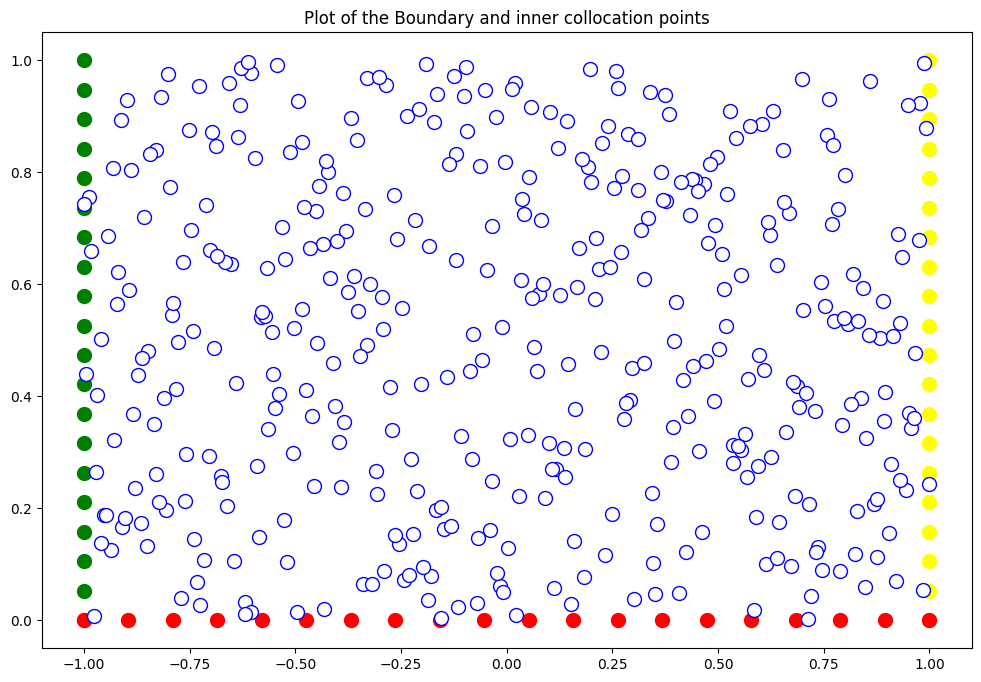

In [61]:
#We can visualize the data to understand them clearly
%matplotlib inline
def for_visuals(cfg):
    x = torch.linspace(cfg.x0,cfg.xf, 20).view(-1,1)
    t = torch.linspace(0,1, 20).view(-1,1)
    x_inner = cfg.x0 + (cfg.xf - cfg.x0)*torch.tensor(lhs(1,400)).float()
    t_inner = 0 + (1 - 0)*torch.tensor(lhs(1,400)).float()
    x_bound_left = -torch.ones_like(t)
    x_bound_right = torch.ones_like(t)
    t_initial = torch.zeros_like(x)
    plt.figure(figsize = (12,8))
    plt.title("Plot of the Boundary and inner collocation points")
    plt.scatter(x_bound_left, t,  marker='o', s=100, c='green') #u(-1,t)
    plt.scatter(x_bound_right, t,  marker='o', s=100, c='yellow') #u(1,t)
    plt.scatter(x, t_initial,  marker='o', s=100, c='red') #u(x,0)
    plt.scatter(x_inner, t_inner,  marker='o', s=100,color = 'white', edgecolors = 'blue')
    plt.show()
for_visuals(cfg)

### The PINN Training

In [62]:
#first we define our NN module
class PINN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.activation = nn.Tanh()
        self.layers = cfg.layers #The number of layers

        #Defining the linear layers
        self.linears = self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        #Initializing the weights
        #self.apply(weights_init)
        for i in range(len(self.layers)-1):
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
          nn.init.zeros_(self.linears[i].bias.data)

    def forward(self,x, t):
        assert x.shape == t.shape, f"Shape Mismatch!! shape of x: {x.shape}, shape of t: {t.shape}"
        a = torch.cat((x,t), dim = 1).float()
        for linear in self.linears[:-1]:
            a = self.activation(linear(a))
        return self.linears[-1](a)

In [63]:
#Defining the necessary functions needed for training
def PDEloss(NN,x,t):
    g1 = x.clone().to(device); g2 = t.clone().to(device)
    g1.requires_grad = True; g2.requires_grad = True #For Automatic differentiation
    u_hat = NN(g1,g2) #The forward pass
    #u_hat_x = torch.autograd.grad(u_hat, g1, torch.ones_like(u_hat), create_graph = True)[0]
    #u_hat_t = torch.autograd.grad(u_hat, g2, torch.ones_like(u_hat), create_graph = True)[0]
    #u_hat_xx = torch.autograd.grad(u_hat_x, g1, torch.ones_like(u_hat_x), create_graph = True)[0]
    u_hat_t = dfx(u_hat, g2); u_hat_x = dfx(u_hat, g1); u_hat_xx = dfx(u_hat_x, g1) 
    res = u_hat_t + u_hat*u_hat_x - cfg.nu * u_hat_xx #The Burgers equation
    Loss = nn.MSELoss()
    loss = Loss(res.float(), torch.zeros_like(res).float())
    return loss

def boundary_loss(NN,x,t,u):
    u_hat = NN(x,t)
    assert u_hat.shape == u.shape, f"Shape Mismatch! prediction shape:{u_hat.shape}, target shape: {u.shape}"
    Loss = nn.MSELoss()
    loss = Loss(u.float(),u_hat.float())
    return loss


#### Learning Rate Finder

This allows us to find the best learning rate for our problem.

In [64]:
model_lr = PINN(cfg)
model_lr.to(device)
print(model_lr)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

PINN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=125, bias=True)
    (1): Linear(in_features=125, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=125, bias=True)
    (3): Linear(in_features=125, out_features=1, bias=True)
  )
)


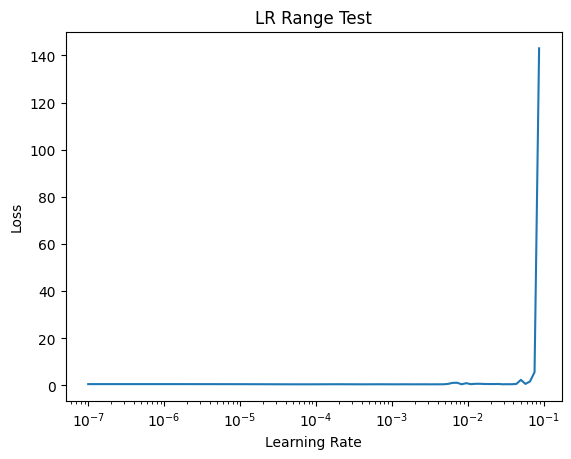

In [65]:
losses = []
lrs = []

#Training for different learning rates between [1e-7,0.1]
start_lr = 1e-7
end_lr = 1e-1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

#Initial learning rate
lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss = PDEloss(model_lr,x_inner, t_inner)
    bound_right_loss = boundary_loss(model_lr,x_bound_right,t_bound, u_bound_right)
    bound_left_loss = boundary_loss(model_lr,x_bound_left,t_bound, u_bound_left)
    initial_loss = boundary_loss(model_lr,x_initial,t_initial, u_init)
    loss = pde_loss + bound_right_loss + bound_left_loss + initial_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

Points to note from the plot:
* The loss gradually decreases from $10^{-7}$ to around $10^{-2}$
* Then, the minimum loss appears around $10^{-2}$, but explodes and unstable after that. This is a sign that the learning rate is too high.
* Hence, we will choose our learning to be $10^{-3}$ or something close to it.

> **It is important to note that the plot can change between runs but in general will look similar. You can run it severally for an optimized selection of the learning rate**

#### Training

In [66]:
model = PINN(cfg)
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

PINN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=125, bias=True)
    (1): Linear(in_features=125, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=125, bias=True)
    (3): Linear(in_features=125, out_features=1, bias=True)
  )
)


In [67]:
metrics = {'total_loss':[], 'pde_loss':[], 'initial_loss':[], 'bound_loss':[]}
#Parameters for best loss
best_loss = 0.1  # To track best loss. You can set the value to as large or small as you want
best_epoch = 0   # To track best epoch
#Checkpoint for best model
os.makedirs(cfg.checkpoint_dir, exist_ok=True) #Check the directory exists or create a new one
best_model_path = os.path.join(cfg.checkpoint_dir, "pinn_burgers_1d_best.pt")

stime = time.time()
for iter in range(cfg.num_epoch + 1):
    optimizer.zero_grad()
    #The PDE Loss
    pde_loss = PDEloss(model,x_inner, t_inner)
    metrics['pde_loss'].append(pde_loss.item())
    #The loss at the initial condition
    initial_loss = boundary_loss(model,x_initial,t_initial, u_init)
    metrics['initial_loss'].append(initial_loss.item())
    #The loss at the boundary
    bound_loss_left = boundary_loss(model,x_bound_left,t_bound,u_bound_left)
    bound_loss_right = boundary_loss(model,x_bound_right,t_bound, u_bound_right)
    bound_loss = bound_loss_left + bound_loss_right
    metrics['bound_loss'].append(bound_loss.item())
    #Total loss
    loss = pde_loss + bound_loss + initial_loss #More weight to the initial condition
    metrics['total_loss'].append(loss.item())
    if iter % (cfg.num_epoch // 10) == 0:
        print(f"Epoch: {iter} --- loss: {loss.item()}")
    
    loss.backward()
    optimizer.step()
    #Saving the best model
    if loss.item()  < best_loss:
        best_loss = loss.item()
        best_epoch = iter
        torch.save(model.state_dict(), best_model_path)
    ftime = time.time()
ttime = (ftime - stime)/60
print(f'Total training time is {ttime} minutes')
print(f"Best model is saved at epoch {best_epoch} with loss {best_loss:.6f}")

Epoch: 0 --- loss: 0.6194846630096436
Epoch: 1000 --- loss: 0.0903191789984703
Epoch: 2000 --- loss: 0.07322882860898972
Epoch: 3000 --- loss: 0.03782594949007034
Epoch: 4000 --- loss: 0.02043699100613594
Epoch: 5000 --- loss: 0.0072612036019563675
Epoch: 6000 --- loss: 0.0034892044495791197
Epoch: 7000 --- loss: 0.007741165347397327
Epoch: 8000 --- loss: 0.00199638563208282
Epoch: 9000 --- loss: 0.0013466409873217344
Epoch: 10000 --- loss: 0.0008579266141168773
Total training time is 1.755938212076823 minutes
Best model is saved at epoch 9900 with loss 0.000769


### Evaluation

In [ ]:
#checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("pinn_burgers_1d_*.pt"))[-1]
##Loading the best model
#model.load_state_dict(torch.load(checkpoint_path))

In [68]:
#Comparing with the reference solution, we first load the solution
data = np.load("C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/Burgers.npz")
t_ref = data["t"]; x_ref = data["x"]; u_ref = data["usol"]
x_ref.shape

(256, 1)

In [69]:
#Preparing the testing data
x_new = torch.linspace(cfg.x0,cfg.xf, cfg.spatial_resolution).view(-1,1).float()
t_new = torch.linspace(0,1, cfg.temporal_resolution).view(-1,1).float()
X,T = torch.meshgrid(x_new.squeeze(1),t_new.squeeze(1), indexing='ij')
x_test = X.reshape(-1,1); t_test = T.reshape(-1,1)
print(f"Shape of spatial and temporal testing collocation points: {x_test.shape}, {t_test.shape}")

Shape of spatial and temporal testing collocation points: torch.Size([45000, 1]), torch.Size([45000, 1])


In [70]:
model.eval()
#Testing the initial data prediction: u(x,0)
t_test_init = torch.zeros_like(x_new)
print(f"Shape of spatial and temporal initial testing collocation points: {x_new.shape}, {t_test_init.shape}")

u_pinn_init = model(x_new.to(device), t_test_init.to(device)).detach().cpu()

print(f"Shape of initial condition prediction: {u_pinn_init.shape}")

Shape of spatial and temporal initial testing collocation points: torch.Size([300, 1]), torch.Size([300, 1])
Shape of initial condition prediction: torch.Size([300, 1])


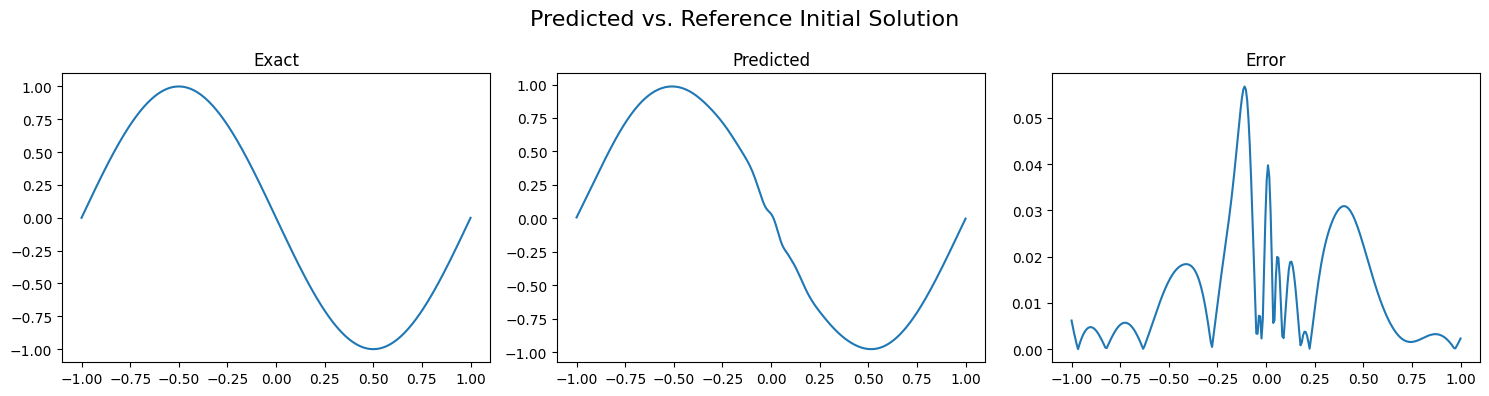

In [71]:
#First we plot the prediction of the initial solution and the exact initial solution
%matplotlib inline
u_init = cfg.init_cond(x_new)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Predicted vs. Reference Initial Solution", fontsize=16)
# Plot each function in its own subplot
ax1.plot(x_new, u_init)
ax1.set_title("Exact")

ax2.plot(x_new, u_pinn_init)
ax2.set_title("Predicted")

diff = torch.abs(u_init - u_pinn_init)
ax3.plot(x_new, diff)
ax3.set_title("Error")

plt.tight_layout()
plt.show()

In [72]:
X,T = torch.meshgrid(torch.tensor(x_ref).squeeze(1), torch.tensor(t_ref).squeeze(1), indexing='xy')
x_ref_test = X.reshape(-1,1); t_ref_test = T.reshape(-1,1)
u_ref_test = model(x_ref_test.to(device), t_ref_test.to(device))

u_ref_test = u_ref_test.reshape(shape=[100,256]).transpose(1,0).detach().cpu().numpy()

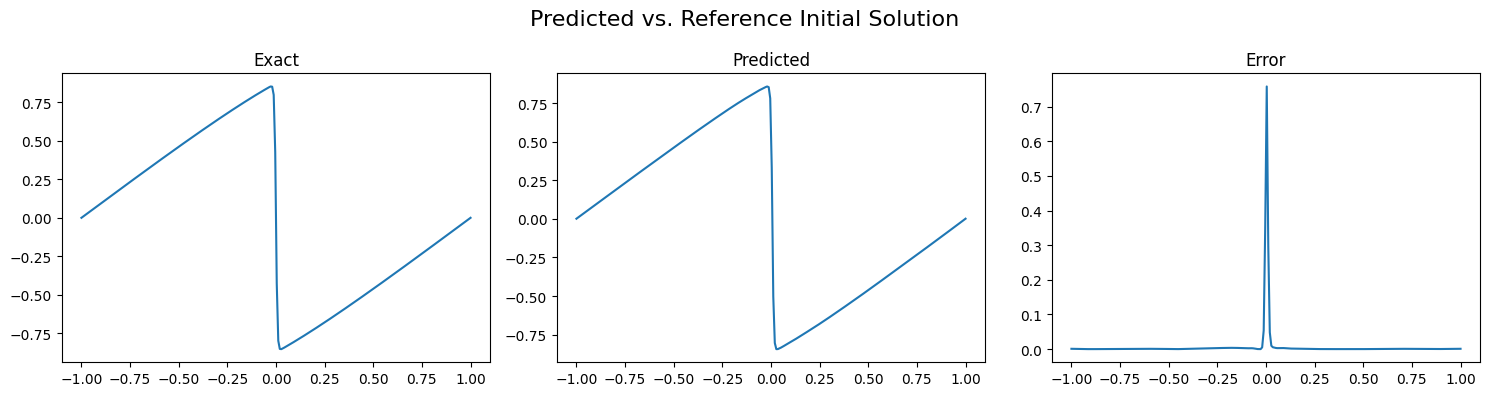

In [87]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle("Predicted vs. Reference Initial Solution", fontsize=16)
# Plot each function in its own subplot
n = 75
ax1.plot(x_ref, u_ref[:,n].reshape(-1,1))
ax1.set_title("Exact")

ax2.plot(x_ref, u_ref_test[:,n].reshape(-1,1))
ax2.set_title("Predicted")

diff = np.abs(u_ref[:,n] - u_ref_test[:,n])
ax3.plot(x_ref, diff.reshape(-1,1))
ax3.set_title("Error")

plt.tight_layout()
plt.show()

> Finally, we will create a moving plot to visualize how shocks develop in the Burger's equation over time.

In [86]:
%matplotlib qt
# Plot setup
fig, ax = plt.subplots()
line, = ax.plot(x_ref, u_ref_test[:, 0].reshape(-1,1))

for i in range(100):
    line.set_ydata(u_ref_test[:, i].reshape(-1,1))
    ax.set_title(f"Time step {i}")
    plt.pause(0.05)

plt.show()

